# 01 - Data Preparation: ISO New England Hourly Demand

## 📌 Objective
In this notebook, we load and clean the ISO New England hourly electricity demand data (2021–2025) from the U.S. EIA.  
Our goal is to produce a tidy dataset with two key columns:
- `datetime`
- `demand_mw`

This cleaned dataset will serve as the foundation for forecasting models in later notebooks.

### 🔹 Data Ingestion

Hourly New England load data is sourced from the **U.S. Energy Information Administration (Nov 2025)**:

⚡ EIA Wholesale Electricity Markets Archive  
https://www.eia.gov/electricity/wholesalemarkets/csv/

Raw hourly ISO-New England load CSVs are downloaded automatically using `download.py` into `data/raw/`.  
This notebook loads all available years dynamically so the workflow remains reproducible without shipping raw data in the repository.

📌 Note: EIA recently disabled directory browsing on the `/csv/` endpoint. Files remain downloadable via the direct URLs in the `download.py` script.

In [1]:
!python ../data/download.py

  → Saved to /Users/faisalmahmood/Documents/iso-ne-load-forecasting/data/raw/isone_load-ard-nat_hr_2021.csv
  → Saved to /Users/faisalmahmood/Documents/iso-ne-load-forecasting/data/raw/isone_load-ard-nat_hr_2022.csv
  → Saved to /Users/faisalmahmood/Documents/iso-ne-load-forecasting/data/raw/isone_load-ard-nat_hr_2023.csv
  → Saved to /Users/faisalmahmood/Documents/iso-ne-load-forecasting/data/raw/isone_load-ard-nat_hr_2024.csv
  → Saved to /Users/faisalmahmood/Documents/iso-ne-load-forecasting/data/raw/isone_load-ard-nat_hr_2025.csv

Done — files saved to data/raw/


In [2]:
# --- 1. Import libraries ---
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings("ignore")

# --- 2. Set data directory ---
raw_dir = "../data/raw/"   # adjust path if needed
processed_dir = "../data/processed/"
os.makedirs(processed_dir, exist_ok=True)

# --- 3. Collect raw CSVs ---
files = sorted(glob.glob(os.path.join(raw_dir, "isone_load-ard-nat_hr_*.csv")))
print("Found files:", [os.path.basename(f) for f in files])

Found files: ['isone_load-ard-nat_hr_2021.csv', 'isone_load-ard-nat_hr_2022.csv', 'isone_load-ard-nat_hr_2023.csv', 'isone_load-ard-nat_hr_2024.csv', 'isone_load-ard-nat_hr_2025.csv']


## 🔍 Step 1: Inspect File Structure
Before combining, let’s preview the first few rows from each file to understand the format.


In [3]:
# --- 4. Inspect first few rows of each file ---
file_samples = {}
for f in files:
    df = pd.read_csv(f, skiprows=3, header=None, nrows=5)
    file_samples[os.path.basename(f)] = df.head()

file_samples

{'isone_load-ard-nat_hr_2021.csv':                                  0  \
 0  UTC Timestamp (Interval Ending)   
 1              2021-02-11 21:00:00   
 2              2021-02-11 22:00:00   
 3              2021-02-11 23:00:00   
 4              2021-02-12 00:00:00   
 
                                                    1  \
 0  Local Timestamp Eastern Time (Interval Beginning)   
 1                                2021-02-11 15:00:00   
 2                                2021-02-11 16:00:00   
 3                                2021-02-11 17:00:00   
 4                                2021-02-11 18:00:00   
 
                                                 2           3            4  \
 0  Local Timestamp Eastern Time (Interval Ending)  Local Date  Hour Number   
 1                             2021-02-11 16:00:00  2021-02-11           16   
 2                             2021-02-11 17:00:00  2021-02-11           17   
 3                             2021-02-11 18:00:00  2021-02-11        

## 🔍 Step 2: Check Column Consistency
We want to ensure that all files have the same structure before concatenating them.


In [4]:
# --- 5. Check column names across files ---
file_columns = {}

for f in files:
    df = pd.read_csv(f, skiprows=3, header=0, nrows=5)  # read headers properly
    file_columns[os.path.basename(f)] = df.columns.tolist()

# Show results
for fname, cols in file_columns.items():
    print(f"\n{fname}:")
    print(cols)

# Check uniqueness across all files
unique_sets = {tuple(cols) for cols in file_columns.values()}
print("\nNumber of unique column sets found:", len(unique_sets))

# Assert all files have the same column structure
assert len(unique_sets) == 1, "Column names differ across files! Check manually."
print("✅ All files have matching column names.")



isone_load-ard-nat_hr_2021.csv:
['UTC Timestamp (Interval Ending)', 'Local Timestamp Eastern Time (Interval Beginning)', 'Local Timestamp Eastern Time (Interval Ending)', 'Local Date', 'Hour Number', 'Total Load (MW)', 'Asset Related Demand (MW)', 'Native Load (MW)']

isone_load-ard-nat_hr_2022.csv:
['UTC Timestamp (Interval Ending)', 'Local Timestamp Eastern Time (Interval Beginning)', 'Local Timestamp Eastern Time (Interval Ending)', 'Local Date', 'Hour Number', 'Total Load (MW)', 'Asset Related Demand (MW)', 'Native Load (MW)']

isone_load-ard-nat_hr_2023.csv:
['UTC Timestamp (Interval Ending)', 'Local Timestamp Eastern Time (Interval Beginning)', 'Local Timestamp Eastern Time (Interval Ending)', 'Local Date', 'Hour Number', 'Total Load (MW)', 'Asset Related Demand (MW)', 'Native Load (MW)']

isone_load-ard-nat_hr_2024.csv:
['UTC Timestamp (Interval Ending)', 'Local Timestamp Eastern Time (Interval Beginning)', 'Local Timestamp Eastern Time (Interval Ending)', 'Local Date', 'Hour N

In [5]:
display(df)

,UTC Timestamp (Interval Ending),Local Timestamp Eastern Time (Interval Beginning),Local Timestamp Eastern Time (Interval Ending),Local Date,Hour Number,Total Load (MW),Asset Related Demand (MW),Native Load (MW)
0,2025-01-01 06:00:00,2025-01-01 00:00:00,2025-01-01 01:00:00,2025-01-01,1,11293.262,16.176,11277.086
1,2025-01-01 07:00:00,2025-01-01 01:00:00,2025-01-01 02:00:00,2025-01-01,2,11146.671,275.272,10871.399
2,2025-01-01 08:00:00,2025-01-01 02:00:00,2025-01-01 03:00:00,2025-01-01,3,10809.622,272.946,10536.676
3,2025-01-01 09:00:00,2025-01-01 03:00:00,2025-01-01 04:00:00,2025-01-01,4,10602.406,272.718,10329.688
4,2025-01-01 10:00:00,2025-01-01 04:00:00,2025-01-01 05:00:00,2025-01-01,5,10620.653,274.263,10346.390


## ✅ Step 3: Combine the files into one tidy dataframe


In [6]:
dfs = []

for f in files:
    df = pd.read_csv(f, skiprows=3, header=0)
    
    # Select only useful columns
    df = df[[
        "Local Timestamp Eastern Time (Interval Ending)",
        "Total Load (MW)"
    ]]
    
    # Rename columns
    df.columns = ["datetime", "demand_mw"]
    
    # Convert datetime column to pandas datetime
    df["datetime"] = pd.to_datetime(df["datetime"])
    
    # Ensure demand is float
    df["demand_mw"] = df["demand_mw"].astype(float)
    
    dfs.append(df)

# Concatenate all years
data = pd.concat(dfs, ignore_index=True)

# Sort by datetime
data = data.sort_values("datetime").reset_index(drop=True)

# Preview
print(data.shape)
data.head()

(36523, 2)


,datetime,demand_mw
0,2021-02-11 16:00:00,15464.335
1,2021-02-11 17:00:00,16176.375
2,2021-02-11 18:00:00,17365.470
3,2021-02-11 19:00:00,17647.924
4,2021-02-11 20:00:00,17197.014


### 📊 Why We Use **Total Load (MW)**

The dataset includes three demand measures:
- **Total Load (MW):** The complete system demand at each hour.  
- **Native Load (MW):** Demand served by local utilities (retail customers).  
- **Asset-Related Demand (MW):** Demand from customers buying directly in the wholesale market.  

Mathematically:  
**Total Load = Native Load + Asset-Related Demand**

For this project, we focus on **Total Load (MW)** because:
- It represents the **full system demand** across New England.  
- It is the **standard series** used by ISO-NE for operational planning.  
- It avoids having to track or reconcile multiple subsets of demand.  

This makes it the most appropriate target variable for system-level forecasting.


## 🔍 Step 4: Validation checks


In [7]:
# 1. Check for duplicates
duplicates = data.duplicated(subset="datetime").sum()
print("Number of duplicate timestamps:", duplicates)

# 2. Check for missing values
missing = data.isna().sum()
print("\nMissing values per column:")
print(missing)

# 3. Check for negative demand
negatives = (data["demand_mw"] < 0).sum()
print("\nNumber of negative demand values:", negatives)

# 4. Check time continuity (no gaps in hourly frequency)
expected_range = pd.date_range(start=data["datetime"].min(),
                               end=data["datetime"].max(),
                               freq="h")

missing_timestamps = expected_range.difference(data["datetime"])
print("\nNumber of missing hourly timestamps:", len(missing_timestamps))

# Show a few if they exist
if len(missing_timestamps) > 0:
    print("Example missing timestamps:", missing_timestamps[:5])

Number of duplicate timestamps: 4

Missing values per column:
datetime     0
demand_mw    0
dtype: int64

Number of negative demand values: 0

Number of missing hourly timestamps: 1717
Example missing timestamps: DatetimeIndex(['2021-03-14 02:00:00', '2021-12-02 14:00:00',
               '2022-02-20 02:00:00', '2022-02-27 23:00:00',
               '2022-03-03 17:00:00'],
              dtype='datetime64[ns]', freq=None)


## 🔍 Step 5: Impute the missing values using interpolation

In [8]:
# 1) Drop duplicate timestamps
data = data.drop_duplicates(subset="datetime", keep="first")

# 2) Put series on an hourly index (inserts NaNs for missing hours)
s = (
    data.set_index("datetime")["demand_mw"]
        .sort_index()
        .asfreq("H")                # enforce hourly continuity
)

# 3) Helper: compute consecutive-NaN run length per timestamp
isnan   = s.isna()
groups  = (isnan.ne(isnan.shift())).cumsum()   # contiguous True/False blocks
runlen  = s.groupby(groups).apply(lambda x: int(x.isna().sum()) if x.isna().all() else 0)
gap_len = pd.Series(groups.map(runlen.to_dict()).values, index=s.index)

# 4) Seasonal proxies (month/season aware)
lag168       = s.shift(24 * 7)                          # same hour previous week
hour_of_week = s.index.dayofweek * 24 + s.index.hour    # 0..167
month        = s.index.month

# Map month -> season label
season = pd.Categorical(
    np.select(
        [month.isin([12, 1, 2]),
         month.isin([3, 4, 5]),
         month.isin([6, 7, 8]),
         month.isin([9, 10, 11])],
        ["DJF", "MAM", "JJA", "SON"],
        default="UNK"
    ),
    categories=["DJF", "MAM", "JJA", "SON"]
)

tmp = pd.DataFrame(
    {"y": s, "hour_of_week": hour_of_week, "month": month, "season": season},
    index=s.index
)

# Month × hour-of-week profile (12×168); transform ignores NaNs
month_how_mean  = tmp.groupby(["month","hour_of_week"])["y"].transform("mean")
# Season × hour-of-week profile (4×168) fallback
season_how_mean = tmp.groupby(["season","hour_of_week"])["y"].transform("mean")
# Global hour-of-week profile (168) final fallback
how_mean        = tmp.groupby(["hour_of_week"])["y"].transform("mean")

# Compose month → season → global profile
seasonal_profile = month_how_mean.copy()
need = seasonal_profile.isna()
seasonal_profile[need] = season_how_mean[need]
need = seasonal_profile.isna()
seasonal_profile[need] = how_mean[need]

# 5) Rule-based filling with provenance tracking
filled         = s.copy()
is_imputed     = pd.Series(False, index=s.index)
impute_method  = pd.Series("original", index=s.index, dtype="object")

# thresholds (tweak if needed)
SHORT_MAX = 6    # hours
LONG_MIN  = 72   # hours

# short gaps (≤ 6h): time interpolation
short_mask  = isnan & (gap_len <= SHORT_MAX)
filled_time = s.interpolate("time")
filled[short_mask]        = filled_time[short_mask]
is_imputed[short_mask]    = True
impute_method[short_mask] = "interp_time"

# medium gaps (7..72h): lag168, fallback to month/season HoW profile
med_mask = isnan & (gap_len > SHORT_MAX) & (gap_len <= LONG_MIN)
filled[med_mask]         = lag168[med_mask]
is_imputed[med_mask]     = True
impute_method[med_mask]  = "lag168"

fallback_mask = med_mask & filled.isna()
filled[fallback_mask]         = seasonal_profile[fallback_mask]
impute_method[fallback_mask]  = "month/season_hour_profile"

# long gaps (> 72h): month/season HoW profile
long_mask = isnan & (gap_len > LONG_MIN)
filled[long_mask]         = seasonal_profile[long_mask]
is_imputed[long_mask]     = True
impute_method[long_mask]  = "month/season_hour_profile"

# last resort: if anything still NaN, ffill then bfill
still_nan = filled.isna()
if still_nan.any():
    filled = filled.ffill().bfill()
    new_imputed               = still_nan & filled.notna()
    is_imputed[new_imputed]   = True
    impute_method[new_imputed]= "ffill_bfill"

# 6) Assemble cleaned DataFrame
data_clean = pd.DataFrame(
    {
        "demand_mw":    filled.astype(float),
        "is_imputed":   is_imputed.astype(bool),
        "impute_method": pd.Categorical(
            impute_method,
            categories=["original","interp_time","lag168","month/season_hour_profile","ffill_bfill"]
        )
    },
    index=s.index
)
data_clean.index.name = "datetime"

### 🧹 Data Cleaning Notes — Season-Aware Gap Filling

**Goal:** We want to produce a continuous hourly series of ISO-NE demand that is safe for forecasting, while being transparent about where values were imputed and how.

---

#### 1) Standardize and align the timestamps
- **Drop duplicates** by `datetime` (keep first).
- **Sort** by time and **reindex to hourly** (`asfreq("H")`), which inserts `NaN` rows wherever an hour is missing.

#### 2) Diagnose gap length
- Build a boolean mask of missing values and group contiguous `NaN` runs.
- For each timestamp, compute the **length (in hours)** of the gap it belongs to (`gap_len`).  
  This lets us apply different strategies to **short vs. medium vs. long** gaps.

#### 3) Build seasonal reference profiles
- Define **hour-of-week** (`0..167`) = `dayofweek*24 + hour`.
- Map each timestamp to **month (1–12)** and **season**:
  - **DJF** (Dec–Feb), **MAM** (Mar–May), **JJA** (Jun–Aug), **SON** (Sep–Nov).
- Compute three reference means (NaNs ignored):
  1. **Month x hour-of-week** mean (12x168 buckets).
  2. **Season x hour-of-week** mean (4x168) — **fallback** when month profile missing.
  3. **Global hour-of-week** mean (168) — final fallback.
- Also compute **lag-168** (same hour one week earlier) for week-over-week continuity.

#### 4) Rule-based imputation
For each missing hour:
- **Short gaps (≤ 6h):** **time-based linear interpolation** (`interpolate("time")`).  
  *Preserves local continuity for brief outages.*
- **Medium gaps (7–72h):** use **lag-168** (same hour last week).  
  If that’s missing too, **fall back** to the **month/season hour-of-week profile**.
- **Long gaps ( > 72h):** use the **month/season hour-of-week profile** directly.  
  *Keeps February 3pm from looking like July 3pm.*
- **Last resort:** if anything is still `NaN`, **forward-fill then back-fill** (this will be rare).

Every filled value is tagged:
- `is_imputed` → `True` for synthetic points.  
- `impute_method` ∈ `{original, interp_time, lag168, month/season_hour_profile, ffill_bfill}`.

#### 5) Validations
- No remaining `NaN` values.
- Index is strictly **hourly**.
- All `demand_mw` values are **non-negative**.

#### 6) Outputs for downstream notebooks
- Assemble a tidy DataFrame with columns:
  - `demand_mw`, `is_imputed`, `impute_method` (categorical).
- Save to `../data/processed/isone_demand_clean.csv` (Parquet optional).
- Print a short summary (total hours, number/percent imputed, method counts).

---

#### Why this design?
- **Forecast-ready:** most time-series models assume a continuous, evenly-spaced index.
- **Season-aware:** long gaps are filled with **month/season-consistent** patterns, not flat lines.
- **Transparent:** this design allows plots to **color-code** imputed points and allow metrics to **exclude** them in evaluation.

#### Notes & limitations
- Very long outages are reconstructed using typical seasonal patterns; unusual events
  (heatwaves/holidays) during those windows will be **smoothed**. This is documented via `is_imputed`.
- For business reporting where totals matter, the continuity helps; for scientific auditing,
  it would be best to consider labeling or removing imputed windows in an analysis sensitive to synthetic data.


## 🔍 Step 6: Visualize the frequency and timings of the imputations


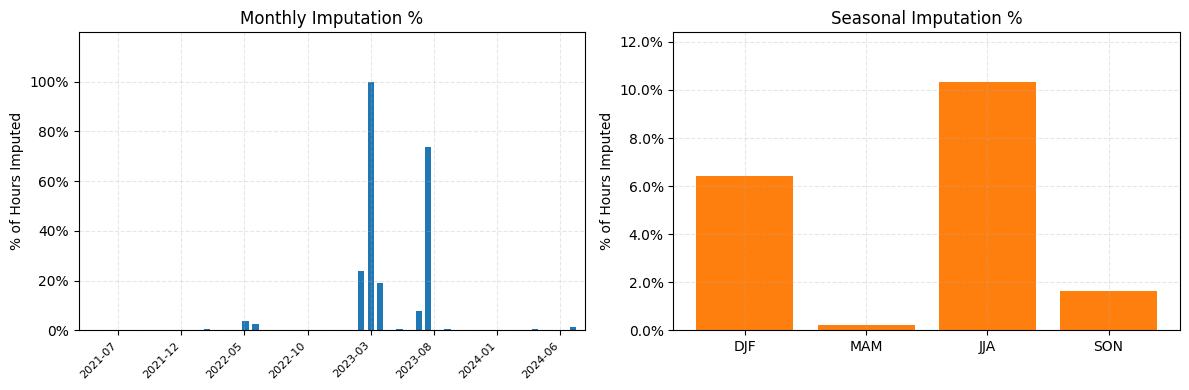

In [9]:
# --- Compute summaries ---
monthly_imp = (
    data_clean.resample("M")["is_imputed"]
    .mean()
    .mul(100)
    .rename("imputed_pct")
)

seasonal_imp = (
    data_clean.assign(
        season=pd.Categorical(
            np.select(
                [data_clean.index.month.isin([12,1,2]),
                 data_clean.index.month.isin([3,4,5]),
                 data_clean.index.month.isin([6,7,8]),
                 data_clean.index.month.isin([9,10,11])],
                ["DJF","MAM","JJA","SON"],
                default="UNK"
            ),
            categories=["DJF","MAM","JJA","SON"]
        )
    )
    .groupby("season")["is_imputed"]
    .mean()
    .mul(100)
)

# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# 1️⃣ Monthly plot
ax[0].bar(monthly_imp.index, monthly_imp.values, width=20)
ax[0].set_title("Monthly Imputation %")
ax[0].set_ylabel("% of Hours Imputed")
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0].grid(alpha=0.3, linestyle="--")
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(nbins=10))  # Changed mticker to mtick
ax[0].set_xticklabels([d.strftime("%Y-%m") for d in monthly_imp.index[::max(1, len(monthly_imp)//10)]], rotation=45,ha="right",fontsize=8)
ax[0].set_ylim(0, max(10, monthly_imp.max() * 1.2))
ax[0].margins(x=0)

# 2️⃣ Seasonal plot
ax[1].bar(seasonal_imp.index, seasonal_imp.values, color="tab:orange")
ax[1].set_title("Seasonal Imputation %")
ax[1].set_ylabel("% of Hours Imputed")
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].grid(alpha=0.3, linestyle="--")
ax[1].set_ylim(0, max(10, seasonal_imp.max() * 1.2))

plt.tight_layout()
plt.show()

## ✅ Step 7: Final Validation and Summary

We seek to verify that this dataset is now cleaned and ready for analysis.

In [10]:
# ✅ FINAL VALIDATION & SUMMARY (with descriptions)

from IPython.display import display

df = data_clean.copy()
assert isinstance(df.index, pd.DatetimeIndex), "Index must be a DatetimeIndex."

# --- Integrity checks ---
assert df.index.is_monotonic_increasing, "Index not sorted ascending."
assert df.index.is_unique, "Duplicate timestamps present."
assert df["demand_mw"].isna().sum() == 0, "NaNs remain in demand_mw."
assert (df["demand_mw"] >= 0).all(), "Negative demand values found."

# Hourly continuity (no missing or extra hours)
start, end = df.index.min(), df.index.max()
expected = pd.date_range(start=start, end=end, freq="h")
missing = expected.difference(df.index)
extra   = df.index.difference(expected)
assert len(missing) == 0 and len(extra) == 0, (
    f"Index not strictly hourly. Missing: {len(missing)}, Extra: {len(extra)}"
)

# --- Summaries ---
total = len(df)
imp_count = int(df["is_imputed"].sum())
imp_pct = round(100 * imp_count / total, 2)

summary = pd.DataFrame(
    {
        "start": [start],
        "end": [end],
        "rows": [total],
        "imputed_rows": [imp_count],
        "imputed_pct": [imp_pct],
        "min_demand_mw": [df["demand_mw"].min()],
        "max_demand_mw": [df["demand_mw"].max()],
    }
)

# --- Imputation methods with descriptions ---
method_descriptions = {
    "original": "Original recorded value (no imputation)",
    "interp_time": "Time-based linear interpolation (≤6h gap)",
    "lag168": "Same hour of previous week (7–72h gap)",
    "month/season_hour_profile": "Season-aware hourly profile (for long gaps >72h)",
    "ffill_bfill": "Forward/backward fill fallback (rare)",
}

method_counts = (
    df["impute_method"]
    .value_counts(dropna=False)
    .rename("count")
    .to_frame()
)
method_counts["percent"] = (method_counts["count"] / total * 100).round(2)
method_counts["description"] = (
    method_counts.index.map(method_descriptions).fillna("N/A")
)
summary["imputed_pct"] = summary["imputed_pct"].map(lambda x: f"{x:.2f}%")
method_counts["percent"] = method_counts["percent"].map(lambda x: f"{x:.2f}%")

# --- Display ---
print("📦 Final Dataset Summary")
display(summary)

print("\n🧭 Imputation Methods Breakdown")
display(method_counts[["count", "percent", "description"]])

print("\n✅ Final validation passed. Dataset is contiguous hourly, non-negative, and free of NaNs.")


📦 Final Dataset Summary


,start,end,rows,imputed_rows,imputed_pct,min_demand_mw,max_demand_mw
0,2021-02-11 16:00:00,2025-06-23 19:00:00,38236,1717,4.49%,6031.537,25100.926



🧭 Imputation Methods Breakdown


,count,percent,description
impute_method,,,
original,36519,95.51%,Original recorded value (no imputation)
month/season_hour_profile,1575,4.12%,Season-aware hourly profile (for long gaps >72h)
lag168,101,0.26%,Same hour of previous week (7–72h gap)
interp_time,41,0.11%,Time-based linear interpolation (≤6h gap)
ffill_bfill,0,0.00%,Forward/backward fill fallback (rare)



✅ Final validation passed. Dataset is contiguous hourly, non-negative, and free of NaNs.


## 💾 Step 8: Save the processed dataset for the 02_modeling notebook

In [11]:
# 💾 Save processed dataset
import os

processed_dir = "../data/processed/"
os.makedirs(processed_dir, exist_ok=True)

out_path = os.path.join(processed_dir, "isone_demand_clean.csv")

# Reset index so 'datetime' becomes a column
data_clean.reset_index().to_csv(out_path, index=False)

print(f"✅ Clean dataset saved to: {out_path}")
print(f"Rows saved: {len(data_clean):,}")
print(f"Columns: {list(data_clean.columns)}")


✅ Clean dataset saved to: ../data/processed/isone_demand_clean.csv
Rows saved: 38,236
Columns: ['demand_mw', 'is_imputed', 'impute_method']
